## Assignment 1 
**Alessandro Palma**  
**Thomas Lieber**

Initially, we retrieve and parse the data concerning both ratings, movies and users.

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

**Data parsing**

Parse the data and retrieve the ratings

In [2]:
#Import the Data Frame containing the ratings.
data = np.genfromtxt('./ml-1m/ratings.dat',
                     delimiter='::', usecols = (0, 1, 2), dtype = int)

ratings = pd.DataFrame(data)
ratings.columns = ['user', 'movie', 'rating']

In [3]:
#Generate the training sparse matrix
rating_mat = ratings.pivot(index='user', columns='movie', values='rating')

In [6]:
#We will work with numpy arrays since faster. 
ratings_np = np.matrix(ratings)
rating_mat_np = np.array(rating_mat)

#ratings_np represents the data frame of ratings with information encoded as <userID, moviesID, rating>. 
#rating_mat_np is the sparse matrix of ratings we use for the optimization algorithm.

**Implement the UV decomposition algorithm**

The UV matrix decomposition algorithm aims to decompose a matrix $X$ to two lower rank matrices $U$ and $V$ such that their dot product represents a good approximation of $X$. This method can be adopted for the development of a recommendation system that approximates the utility matrix $X$ as the matrix product between a user matrix $U$ and an item matrix $V$. The principle behind the optimization algorithm lies in the subsequent substitution of all elements of the matrices $U$ and $V$ with variables to optimize one at the time. Upon encoding  one element of the two matrices with an independent variable, the square error between the utility matrix $X$ and the product $UV$ is subject to quadratic optimization. As we find the optimal value of one variable representing one element of either $U$ or $V$, we pass to the next entry to optimize of the same matrix. 

We will therefore optimize subsequently all elements of $U$ and then all elements of $V$. Performing a single traversal will although not be enough for the optimization to be fulfilled. Indeed, when a value is optimized, this means that previously already optimized values could be further improved by means of subsequent cycles of the algorithm, which prompts us to carry on with the same logic until a final convergence is met. In practice, we let the algorithm cycle for approximately 40 runs and evaluate its performance in the end.

**Estimate accuracy with iter = 20**

In [47]:
def initialize(ratings, n_users, n_movies, K):
    '''
    Given a rating data frame, the number of users and the number of movies, the algorithm initializes 
    two matrices U and V of dimensions n_users*K and K*n_movies
    '''
    #Following the suggestions of the book, we use as initialization value the square root of the average value of the 
    #rating matrix divided by K. Then we introduce some random noise. 
    nan_mean = np.mean(ratings['rating'])
    initialize = np.sqrt(nan_mean/K)
    U = (np.repeat(initialize, K*n_users) + np.random.normal(0,1,K*n_users)).reshape((n_users, K))
    V = (np.repeat(initialize, K*n_movies) + np.random.normal(0,1,K*n_movies)).reshape((K, n_movies))
    return U,V

def RMSE(ratings, X, UV):
    '''
    RMSE computes the root mean squared error of two matrices, X and UM. Ratings is an array containing the list of
    ratings recorded as <userID, itemID, rating>.
    '''
    diff = X - UV
    n_non_missing = len(ratings)
    rmse = np.sqrt(np.nansum(diff**2)/n_non_missing)
    return rmse

def MAE(ratings, X, UV):
    '''
    MAE computes the mean absolute error of two matrices, X and UV.
    '''
    diff = X - UV
    n_non_missing = len(ratings)
    mae = np.nansum(abs(diff))/n_non_missing
    return mae

def UV_decomp(ratings, X, U, V, K = 10, iter = 40):
    '''
    Implement the UV matrix decomposition algorithm.
    '''
    res = []
    #Fix the old and new RMSE values.
    RMSE_old = 1000
    RMSE_new = RMSE(ratings, X, U.dot(V))
    #cols_X and rows_X simply contain the indexes of the rows and columns of the
    #matrix X. They will be used for cycling.
    cols_X = np.arange(np.size(X,1))
    rows_X = np.arange(np.size(X,0))
    #Features is a vector from 0 to K-1.
    features = np.arange(K)
    count = 1
    while count<=iter:
        RMSE_old = RMSE_new
        #Cycle across the rows and columns of U. 
        for r in rows_X:
            #To implement update formulas you need to get the columns
            #of X such that their value at the row r is not NaN. 
            non_missing_cols = cols_X[~ np.isnan(list(X[r,:]))]
            for s in features:               
                num = np.sum(V[s, non_missing_cols] * (X[r, non_missing_cols] - 
                        U[r,np.delete(features, s)].dot(V[np.delete(features, s)][:,non_missing_cols])))
                den = np.sum(V[s,non_missing_cols]**2)
                U[r,s] = num/den
        #Repeat the process to update V
        for s in cols_X: 
            non_missing_rows = rows_X[~ np.isnan(list(X[:, s]))]
            for r in features:   
                num = np.sum(U[non_missing_rows, r] * (X[non_missing_rows, s] - 
                    U[non_missing_rows][:,np.delete(features, r)].dot(V[np.delete(features, r),s])))
                den = np.sum(U[non_missing_rows, r]**2)
                V[r,s] = num/den
        #Compute the matrix product between the new U and V.
        RMSE_new = RMSE(ratings, X , U.dot(V))
        res.append(RMSE_new)
        count += 1 
    return U.dot(V), res

In the following script, we will estimate the test error of our approach for iter = 40 and $k = 10$ via 5-fold cross-validation.

In [16]:
#Implement 5-fold cross validation.

#We will keep a partial error for plotting.
partial_error = []

#Set parameter K.
K = 10

#Set a seed for reproducibility
np.random.seed(888)

#Generate the 5 folds for all rows of the utility matrix of input.
nfolds = 5
folds = np.array([x%nfolds for x in range(len(ratings))])
np.random.shuffle(folds)

#Set up the vectors of errors. 
errors_5folds_mae_training = []
errors_5folds_rmse_training = []
errors_5folds_mae_test = []
errors_5folds_rmse_test = [] 

'''
We will cycle through the possible folds (from 1 to 5) and leave one set of observations (test set) out of the training process.
Then, we use it to perform predictions and compute the error. 
'''

for i in range(5):
    print('Start iteration '+ str(i))
    #Fix the rows of the ratings Data Frame that will be the training set.
    train = ratings.loc[folds!=i, :]
    train_mat = train.pivot(index='user', columns='movie', values='rating')
    train_np = np.matrix(train)
    train_mat_np = np.array(train_mat)
    
    #Create lookup dictionary associating the indices of the numpy array to the
    #respective movieID and userID.
    col_names_train = {train_mat.columns[j]:j for j in range(len(train_mat.columns))}
    row_names_train = {train_mat.index[j]:j for j in range(len(train_mat.index))}   
    
    #Initialize U and V and run the prediction.
    U, V = initialize(train, np.size(train_mat_np,0), np.size(train_mat_np,1), K)
    pred, res = UV_decomp(train_np, train_mat_np, U, V, iter = 40)
    
    #Initialize test set
    test =  ratings.loc[folds == i, :]
    test_np = np.matrix(test)
    test_pred = []
    
    #The global mean of the training matrix will be used as a prediction for the observations that have a missing 
    #movie or user in the training set.
    global_mean = np.mean(train['rating'])
    
    #Create the prediction vector of the test set. If a user or item are not present
    #in the training set, predict their rating as the gloal mean of the training ratings.
    for val in test_np:
        if val[0,0] in row_names_train and val[0,1] in col_names_train:
            test_pred.append(pred[row_names_train[val[0,0]], col_names_train[val[0,1]]])
        else:
            test_pred.append(global_mean)
       
    test_pred = np.array(test_pred)
    test_obs = np.array(test['rating'])
    
    
    #Extra fallback rules to improve performance
    test_pred = np.where(test_pred > 5, 5, test_pred)
    test_pred = np.where(test_pred < 1, 1, test_pred)
    
    #Calculate and store the errors on the training set and test set. 
    errors_5folds_rmse_training.append(RMSE(train_np,train_mat_np,pred))
    errors_5folds_mae_training.append(MAE(train_np, train_mat_np,pred))    
    
    #Calculate the error on the test set and store it.
    test_RMSE = np.sqrt(np.sum((test_pred-test_obs)**2)/len(test_pred)) 
    test_MAE = np.sum(abs(test_pred-test_obs))/len(test_pred)
    errors_5folds_rmse_test.append(test_RMSE)
    errors_5folds_mae_test.append(test_MAE) 
       
    
    partial_error.append(res)   
    print('End of iteration', i)    

Start iteration 0
End of iteration 0
Start iteration 1
End of iteration 1
Start iteration 2
End of iteration 2
Start iteration 3
End of iteration 3
Start iteration 4
End of iteration 4


In [17]:
#Average across the folds to compute the errors. 
cv_error_mae_train = np.mean(errors_5folds_mae_training)
cv_error_rmse_train = np.mean(errors_5folds_rmse_training)
cv_error_mae_test = np.mean(errors_5folds_mae_test)
cv_error_rmse_test = np.mean(errors_5folds_rmse_test)

print('The average rmse over the training set is: ', cv_error_rmse_train)
print('The average mae over the training set is: ', cv_error_mae_train)
print('The average rmse over the test set is: ', cv_error_rmse_test)
print('The average mae over the test set is: ', cv_error_mae_test)

The average rmse over the training set is:  0.7860738710856158
The average mae over the training set is:  0.6158612794987914
The average rmse over the test set is:  0.908370754886924
The average mae over the test set is:  0.7033982469729751


Plot convergence. 

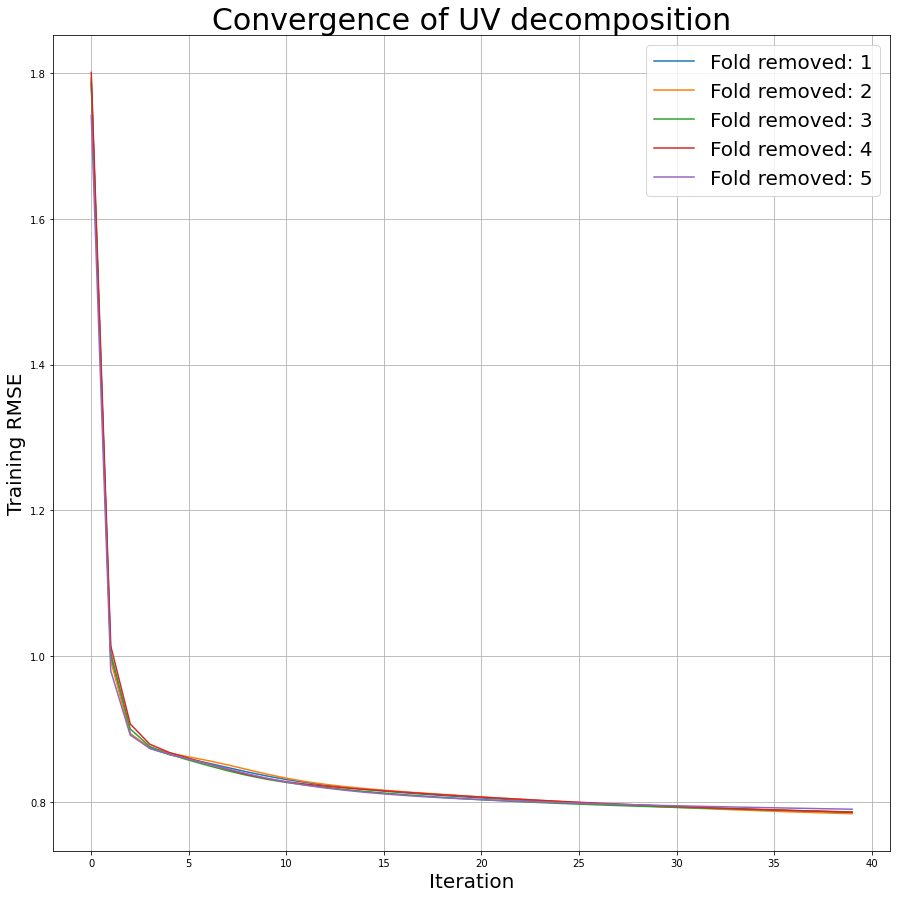

In [18]:
#Plot the convergence on the training set. 
fig = plt.figure(figsize=(15,15))

for i in range(1,6):
    plt.plot(partial_error[i-1], label =  'Fold removed: '+str(i))
plt.legend(loc=1, prop={'size': 20})
plt.grid()
plt.title('Convergence of UV decomposition', fontsize = 30)
plt.ylabel('Training RMSE', fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.show()

**Runtime estimation**

Eventually, we will launch the algorithm once again on the entire utility matrix to estimate the runtime of the algorithm of a single run. 

In [130]:
#Launch the algorithm on all ratings and estimate the runtime. 
U, V = initialize(ratings, np.size(rating_mat,0), np.size(rating_mat,1), K)
start = time.time()
UV_decomp(ratings_np, rating_mat_np, U, V, iter = 40)
end = time.time()

print('The runtime for a single run on all ratings is of '+ str(end-start))

The runtime for a single run on all ratings is of 530.2284262180328


**Experiments with different K and numbers of iterations**

Now, we convert the cross validation program into a function and conduct experiments with different parameters.

In [42]:
def cv(ratings, K, iter):
    #Set a seed for reproducibility
    np.random.seed(888)

    #Generate the 5 folds for all rows of the utility matrix of input.
    nfolds = 5
    folds = np.array([x%nfolds for x in range(len(ratings))])
    np.random.shuffle(folds)

    #Set up the vectors of errors. 
    errors_5folds_mae_training = []
    errors_5folds_rmse_training = []
    errors_5folds_mae_test = []
    errors_5folds_rmse_test = [] 

    '''
    We will cycle through the possible folds (from 1 to 5) and leave one set of observations (test set) out of the training process.
    Then, we use it to perform predictions and compute the error. 
    '''
    
    start = time.time()
    for i in range(5):
        #Fix the rows of the ratings Data Frame that will be the training set.
        train = ratings.loc[folds!=i, :]
        train_mat = train.pivot(index='user', columns='movie', values='rating')
        train_np = np.matrix(train)
        train_mat_np = np.array(train_mat)
    
        #Create lookup dictionary associating the indices of the numpy array to the
        #respective movieID and userID.
        col_names_train = {train_mat.columns[j]:j for j in range(len(train_mat.columns))}
        row_names_train_ = {train_mat.index[j]:j for j in range(len(train_mat.index))}   
    
        #Initialize U and V and run the prediction.
        U, V = initialize(train, np.size(train_mat_np,0), np.size(train_mat_np,1), K)
        pred, res = UV_decomp(train_np, train_mat_np, U, V, K = K, iter = iter)
    
        #Initialize test set
        test =  ratings.loc[folds == i, :]
        test_np = np.matrix(test)
        test_pred = []
    
        #The global mean of the training matrix will be used as a prediction for the observations that have a missing 
        #movie or user in the training set.
        global_mean = np.mean(train['rating'])
    
        #Create the prediction vector of the test set. If a user or item are not present
        #in the training set, predict their rating as the gloal mean if the training matrix.
        for val in test_np:
            if val[0,0] in row_names_train and val[0,1] in col_names_train:
                test_pred.append(pred[row_names_train[val[0,0]], col_names_train[val[0,1]]])
            else:
                test_pred.append(global_mean)
       
        test_pred = np.array(test_pred)
        test_obs = np.array(test['rating'])
    
    
        #Extra fallback rules to improve performance
        test_pred = np.where(test_pred > 5, 5, test_pred)
        test_pred = np.where(test_pred < 1, 1, test_pred)
    
        #Calculate and store the errors on the training set and test set. 
        errors_5folds_rmse_training.append(RMSE(train_np,train_mat_np, pred))
        errors_5folds_mae_training.append(MAE(train_np, train_mat_np, pred))    
    
        #Calculate the error on the test set and store it.
        test_RMSE = np.sqrt(np.sum((test_pred-test_obs)**2)/len(test_pred)) 
        test_MAE = np.sum(abs(test_pred-test_obs))/len(test_pred)
        errors_5folds_rmse_test.append(test_RMSE)
        errors_5folds_mae_test.append(test_MAE) 
       
    
        partial_error.append(res)    
    end = time.time()

    #Average across the folds to compute the errors. 
    cv_error_mae_train = np.mean(errors_5folds_mae_training)
    cv_error_rmse_train = np.mean(errors_5folds_rmse_training)
    cv_error_mae_test = np.mean(errors_5folds_mae_test)
    cv_error_rmse_test = np.mean(errors_5folds_rmse_test)
    
    print('The time elapsed is of: ', end-start)
    print('The average rmse over the training set for iter = ',iter,' and K = ',K,' is: ', cv_error_rmse_train)
    print('The average mae over the training set for iter = ',iter,' and K = ',K,' is: ', cv_error_mae_train)
    print('The average rmse over the test set for iter = ',iter,' and K = ',K,' is: ', cv_error_rmse_test)
    print('The average mae over the test set for iter = ',iter,' and K = ',K,' is: ', cv_error_mae_test)
    return 

Evaluate accuracy for different amounts of iterations

In [43]:
cv(ratings, 10, 10)

The time elapsed is of:  615.3291356563568
The average rmse over the training set for iter =  10  and K =  10  is:  0.8336950900484219
The average mae over the training set for iter =  10  and K =  10  is:  0.6556038720251399
The average rmse over the test set for iter =  10  and K =  10  is:  0.9303417407685423
The average mae over the test set for iter =  10  and K =  10  is:  0.7263148012270412


In [44]:
cv(ratings, 10, 20)

The time elapsed is of:  1257.7003996372223
The average rmse over the training set for iter =  20  and K =  10  is:  0.8063416842841853
The average mae over the training set for iter =  20  and K =  10  is:  0.6327524055735948
The average rmse over the test set for iter =  20  and K =  10  is:  0.91535899725364
The average mae over the test set for iter =  20  and K =  10  is:  0.7116126905637848


In [45]:
cv(ratings, 10, 30)

The time elapsed is of:  2126.8232374191284
The average rmse over the training set for iter =  30  and K =  10  is:  0.794104794442223
The average mae over the training set for iter =  30  and K =  10  is:  0.6225982326128164
The average rmse over the test set for iter =  30  and K =  10  is:  0.9107524178844166
The average mae over the test set for iter =  30  and K =  10  is:  0.7064864754666865


Evaluate accuracy for different values of k 

In [50]:
for k in range(2,10,2):
    cv(ratings, k, 20)

The time elapsed is of:  744.6255009174347
The average rmse over the training set for iter =  20  and K =  2  is:  0.8841573902004999
The average mae over the training set for iter =  20  and K =  2  is:  0.6979955191851637
The average rmse over the test set for iter =  20  and K =  2  is:  0.9057412102643504
The average mae over the test set for iter =  20  and K =  2  is:  0.713301966538945
The time elapsed is of:  847.0215768814087
The average rmse over the training set for iter =  20  and K =  4  is:  0.8574216150123132
The average mae over the training set for iter =  20  and K =  4  is:  0.6750599759648882
The average rmse over the test set for iter =  20  and K =  4  is:  0.9022301522095277
The average mae over the test set for iter =  20  and K =  4  is:  0.7072154143020483
The time elapsed is of:  954.6232228279114
The average rmse over the training set for iter =  20  and K =  6  is:  0.8368457929236817
The average mae over the training set for iter =  20  and K =  6  is:  0.